## Recurrent Neural Network
- shallow (one layer) / deep (an x number of hidden layers)
- each node is a simple function with a simple job
- pattern matching is done through the connection of many nodes to create one powerful function
- this function has an understanding of the data's **sequential nature**
    - using feedback loops that form a sense of memory
    - the sequential nature accounts for the context (the problem word2vec tackles by exploring the 'sliding window'...)
- each node is aware of the output from the other node

### other NLP techniques:
1. **TF-IDF**
    - uses a multi-million-word dictionary object with frequency count (trained on a given corpus)
    - compares the occurence of certain words from a document/sentence and creates a sparse-vector (mostly zeros, with values on the dictionary's 'index' where that specific word occured in the given sentence
    - calculates the 'importance' of a given word in a given sentence by comparing the total frequency with inverted frequency count ("how important is this word in this sentence?")
    - the vectors will be **sparse**
    
2. **word2vec** 
    - for each given word in the sentence, based on a window (2,3 or more tokens) calculates a vector
    - to represent a given sentence, an average value of all the word vectors is calculated
    - the vector of the sentence will be **dense** (shorter, no zeros)
    
3. **doc2vec**
    - a more sophisticated way to calculate sentence/document vector (it doesn't lose information by averaging the value)
    - the vector of the sentence will be **dense**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 100)

data = pd.read_csv('dataset/SMSSpamCollection.csv', sep='delimiter')
messages = pd.DataFrame(columns=['label','text'])
messages[['label','text']] = data['v1\tv2'].str.split('\t', expand=True)

# the labels will be converted from str to int data (less memory consuming)
labels = np.where(messages['label'] == 'spam', 1,0)


print(messages.head())



X_train, X_test, y_train, y_test = train_test_split(
    messages['text'],
    labels,
    test_size=0.2
)

print("X_train", X_train.shape)
print(X_test.shape)
print("y_train:", y_train.shape)
print(y_test.shape)

  label  \
0   ham   
1   ham   
2  spam   
3   ham   
4   ham   

                                                                                                  text  
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...  
1                                                                        Ok lar... Joking wif u oni...  
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...  
3                                                    U dun say so early hor... U c already then say...  
4                                        Nah I don't think he goes to usf, he lives around here though  
X_train (4459,)
(1115,)
y_train: (4459,)
(1115,)


/home/dkarl/anaconda3/envs/nlp-prep-env/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


### preparing data for modelling

In [2]:
# keras
# !conda install keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
# initialize and fit the tokenizer
    # tokenizer also CLEANS the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [4]:
### now the tokenizer has built a vocabulary and assign indices to each token
### the next thing is to pass each sentence (or a message in our case) to a built-in function 
    # that converts each token in a text to a unique integer 
    # (that represents that word in the Tokenizer that we created before) 
    
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test) 


In [5]:
# now check one sentence:
X_train_seq[16]

[55,
 427,
 11,
 69,
 14,
 63,
 55,
 2,
 79,
 13,
 526,
 18,
 1697,
 7,
 35,
 13,
 1698,
 159,
 2029,
 958,
 11,
 1033,
 1457,
 1,
 677,
 11,
 959,
 7,
 550,
 3]

- the list of integers above represent words that occur in that message


In [6]:
# since machine learning models expect the same number of feature for each example they see, 
# --> each SEQuence has to have the SAME LENGTH 
# using the pad_sequences built-in KERAS function

X_train_seq_padded = pad_sequences(X_train_seq, 50)
# the 50 stands for the max length each sequence (sentence/document) should have
X_test_seq_padded = pad_sequences(X_test_seq, 50)

# if the sentence is not long enough, it will 'pad' zeros until the length is at the specified index (50 in this case)

In [7]:
X_train_seq_padded[16]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   55,  427,
         11,   69,   14,   63,   55,    2,   79,   13,  526,   18, 1697,
          7,   35,   13, 1698,  159, 2029,  958,   11, 1033, 1457,    1,
        677,   11,  959,    7,  550,    3], dtype=int32)

In [8]:
print(X_train_seq_padded.shape)
print(type(X_train_seq_padded))

(4459, 50)
<class 'numpy.ndarray'>


### Building the model

In [9]:
import keras.backend as K
from keras.layers import Dense,Embedding,LSTM
from keras.models import Sequential 

In [10]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [11]:
model = Sequential() 
# building the model means that we add as much layer to the sequential model as we think are needed
# sequential means that the output dimensionality of one layer is the input d. of the next layer etc.
# the first layer will take the dimensionality (SIZE) of our dataset


# Embedding works the same way as word2vec and doc2vec
    # ---> vector representations of the text
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
    # only one number represents the dimensionality of the OUTPUT
    # dropout helps with the regularization
        # it prevents overfitting by killing the best neurons so the other would learn better
# Dense is a fully-connected layer
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          257344    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 266,753
Trainable params: 266,753
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy', precision_m, recall_m]
)

In [13]:
history = model.fit(X_train_seq_padded, # training data
                    y_train,            # training target
                    batch_size=32,      # batch size
                    epochs=10,          # the number of epochs
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 24s 132ms/step - loss: 0.4270 - accuracy: 0.8727 - precision_m: 0.1433 - recall_m: 0.0986 - val_loss: 0.0530 - val_accuracy: 0.9874 - val_precision_m: 0.9535 - val_recall_m: 0.9065
Epoch 2/10
140/140 [==============================] - 16s 115ms/step - loss: 0.0446 - accuracy: 0.9899 - precision_m: 0.9760 - recall_m: 0.9406 - val_loss: 0.0270 - val_accuracy: 0.9946 - val_precision_m: 0.9895 - val_recall_m: 0.9749
Epoch 3/10
140/140 [==============================] - 17s 124ms/step - loss: 0.0171 - accuracy: 0.9962 - precision_m: 0.9855 - recall_m: 0.9840 - val_loss: 0.0308 - val_accuracy: 0.9928 - val_precision_m: 0.9735 - val_recall_m: 0.9781
Epoch 4/10
140/140 [==============================] - 17s 122ms/step - loss: 0.0052 - accuracy: 0.9984 - precision_m: 0.9861 - recall_m: 0.9888 - val_loss: 0.0297 - val_accuracy: 0.9910 - val_precision_m: 0.9824 - val_recall_m: 0.9511
Epoch 5/10
140/140 [==============================] - 17s 11

Matplotlib is building the font cache; this may take a moment.


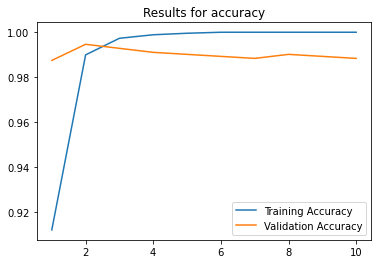

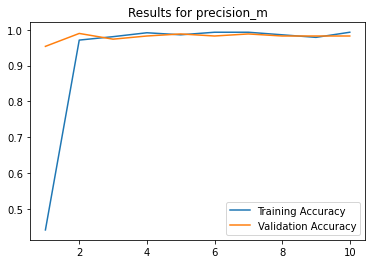

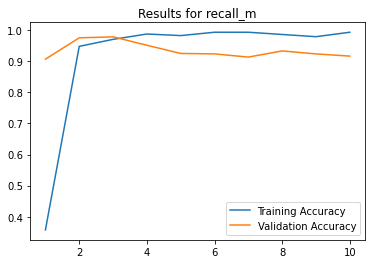

In [15]:
### visualizing the results data ###
%matplotlib inline
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc)+1)
    
    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    
    plt.title("Results for {}".format(i))
    plt.legend()
    
    plt.show
